- Understanding and working with PyTorch computation graphs;
- Working with PyTorch tensor objects;
- Solving the classic XOR problem and understanding model capacity;
- Building complex NN models using PyTorch `Sequential` class and the `nn.Module` class;
- Computing gradients using automatic differentiation and `torch.autograd`.

# PyTorch's computation graphs

PyTorch performs its computations based on a directed acyclic graph (DAG).

Let's say that we have rank 0 tensors $a$, $b$, and $c$ and we want to evaluate $z = 2\times(a-b)+c$.

In [1]:
import torch
def compute_z(a,b,c):
    r1 = torch.sub(a,b)
    r2 = torch.mul(r1,2)
    z = torch.add(r2,c)
    return z

print('Scalar inputs: ', compute_z(torch.tensor(1),torch.tensor(2),torch.tensor(3)))
print('Rank 1 inputs: ', compute_z(torch.tensor([1]),torch.tensor([2]),torch.tensor([3])))
print('Rank 2 inputs: ', compute_z(torch.tensor([[1]]),torch.tensor([[2]]),torch.tensor([[3]])))

Scalar inputs:  tensor(1)
Rank 1 inputs:  tensor([1])
Rank 2 inputs:  tensor([[1]])


In PyTorch, a special tensor object for which gradients need to be computed allows us to store and update the parameters
of our models during training. Such a tensor can be created by just assigning `requires_grad` to `True` on user
specified initial values.

In [2]:
a = torch.tensor(3.14, requires_grad=True)
print(a)
b = torch.tensor([1.,2.,3.], requires_grad=True)
print(b)

tensor(3.1400, requires_grad=True)
tensor([1., 2., 3.], requires_grad=True)


`requires_grad` is set to `False` by default but can be turned on afterwards using `.requires_grad_()` on the tensor.

You will recall that for NN models, initializing model parameters with random weights is necessary to break the
symmetry during backpropagation (otherwise, a multilayer NN would be no more useful than a single-layer NN like logistic
regression (If all neurons start with the same weight, they will continue to update in the same way, effectively making
them redundant)).

When creating a PyTorch tensor, we can also use a random initialization scheme, based on many different probability
distributions.

Let's look at how we can create a tensor with Glorot initialization, which is a classic random initialization scheme
that was proposed by Xavier Glorot.

The basic idea behind this kind of initialization is to roughly balance the variance of the gradients across different
layers. Otherwise, some layers may get too much attention during training while the other layers lag behind.

In [3]:
import torch.nn as nn
torch.manual_seed(1)
w = torch.empty(2,3)
nn.init.xavier_normal_(w)
print(w)

tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


# Computing gradients via automatic differentiation

Optimizing NNs requires computing the gradients of the loss with respect to the NN weights. In addition, gradients have
other applications, such as diagnosing the network to find out why an NN model is making a particular prediction for a
test example.

## Computing the gradients of the loss with respect to trainable variables

PyTorch supports automatic differentiation.

Quick math recap: A partial derivative $\frac{\partial f}{\partial x_1}$ can be understood as the rate of change of a
multivariate function (a function with multiple inputs), with respect to one of its inputs (here $x_1$).

The gradient $\nabla f$ of a function is a vector composed of all the inputs' partial derivatives ($\nabla f =
(\frac{\partial f}{\partial x_1},...,\frac{\partial f}{\partial x_n}))$.

To compute the gradients in PyTorch, we can call the `backward` method from the `torch.autograd` module. It computes
the sum of gradients of the given tensor with regard to leaf nodes (terminal nodes) in the graph.

In [4]:
# Let's compute a simple example
w = torch.tensor(1.0,requires_grad=True)
b = torch.tensor(0.5,requires_grad=True)
x = torch.tensor([1.4])
y = torch.tensor([2.1])
z = torch.add(torch.mul(w,x),b)

loss = (y-z).pow(2).sum()
loss.backward()
print('dL/dw : ',w.grad)
print('dL/db : ',b.grad)

dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)


Computing gradients of the loss with respect to the input example is used for generating adversarial examples.
In computer vision for example, adversarial examples are exxamples that are generated by adding some small,
imperceptible noise o the input example, which results in a deep NN misclassifying them.

# Simplifying implementations of common architectures via the `torch.nn` and `nn.Sequential` modules

In [5]:
model = nn.Sequential(
    nn.Linear(4,16),
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU()
)
model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

In [6]:
# Here we configure the first fully connected layer with the Xavier distribution, and we configure the second fully
# connected layer by computing the L1 penalty term for the weight matrix
nn.init.xavier_uniform_(model[0].weight)
l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()

# Solving a XOR classification problem
The xor ground truth label for the samples is the following:
$$y^{(i)} = \begin{cases}0 \text{ if } x^{(i)}_0\times x^{(i)}_1 < 0 \\ 1 \text{ otherwise}\end{cases}$$

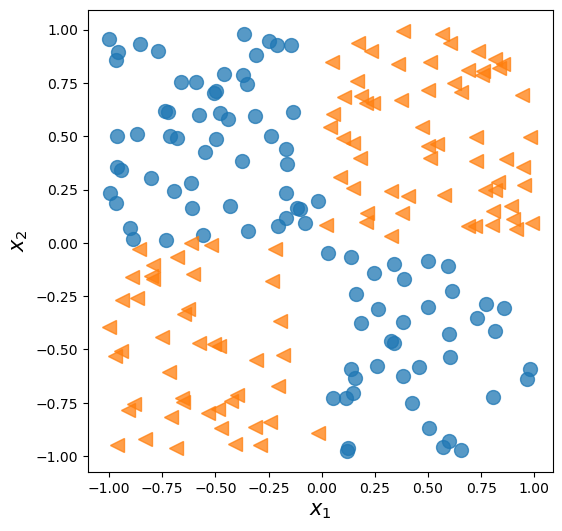

In [7]:
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(1)
np.random.seed(1)
x = np.random.uniform(low=-1,high=1,size=(200,2))
y = np.ones(len(x))
y[x[:,0] * x[:,1] < 0 ] = 0
n_train = 100
x_train = torch.tensor(x[:n_train,:],dtype=torch.float32)
y_train = torch.tensor(y[:n_train],dtype=torch.float32)
x_valid = torch.tensor(x[n_train:,:],dtype=torch.float32)
y_valid = torch.tensor(y[n_train:],dtype=torch.float32)
fig = plt.figure(figsize=(6,6))
plt.plot(x[y==0,0],x[y==0,1],'o',alpha=0.75,markersize=10)
plt.plot(x[y==1,0],x[y==1,1],'<',alpha=0.75,markersize=10)
plt.xlabel(r'$x_1$',size=15)
plt.ylabel(r'$x_2$',size=15)
plt.show()

In [8]:
model = nn.Sequential(
    nn.Linear(2,1),
    nn.Sigmoid()
)

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)

In [9]:
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train,y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds,batch_size,shuffle=True)

In [10]:
torch.manual_seed(1)
num_epochs = 200
def train(model,num_epochs,train_dl,x_valid,y_valid):
    loss_hist_train = [0]*num_epochs
    accuracy_hist_train = [0]*num_epochs
    loss_hist_valid= [0]*num_epochs
    accuracy_hist_valid= [0]*num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:,0]
            loss = loss_fn(pred,y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()
        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size
        pred = model(x_valid)[:,0]
        loss = loss_fn(pred,y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] = is_correct.mean()
    return loss_hist_train,loss_hist_valid,accuracy_hist_train,accuracy_hist_valid

history = train(model,num_epochs,train_dl,x_valid,y_valid)

Text(0.5, 0, 'Epochs')

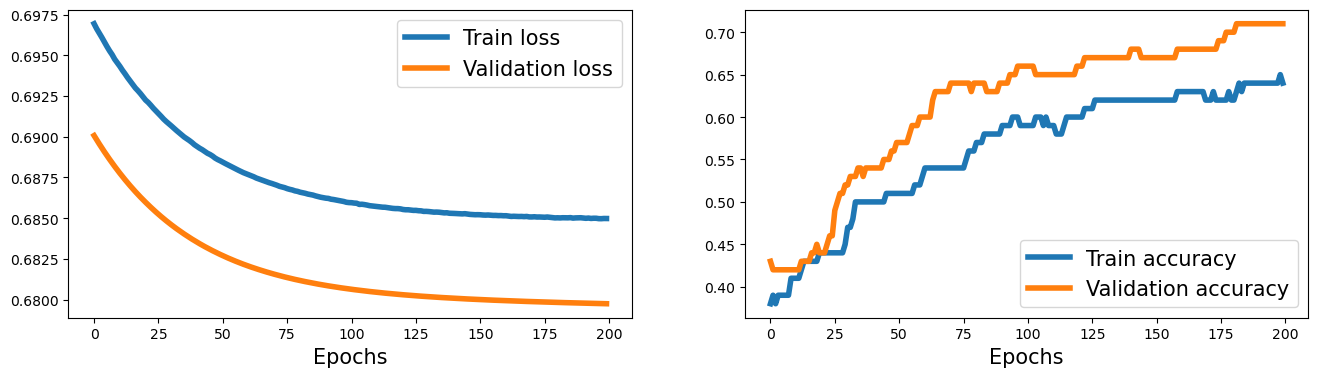

In [11]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0],lw=4)
plt.plot(history[1],lw=4)
plt.legend(["Train loss","Validation loss"],fontsize=15)
ax.set_xlabel("Epochs",size=15)
ax = fig.add_subplot(1,2,2)
plt.plot(history[2],lw=4)
plt.plot(history[3],lw=4)
plt.legend(["Train accuracy","Validation accuracy"],fontsize=15)
ax.set_xlabel("Epochs",size=15)

As we can see, the model with no hidden layer can only derive a linear decision boundary, which is unable to solve the
XOR problem.

To derive a nonlinear decision boundary, we can add one or more hidden layers conncted via nonlinear activation
functions.

**The universal approximation theorem** states that a feedforward NN with a single hidden layer and a relatively large
number of hidden units can approximate arbitrary continuous functions relatively well.

Let's create a more expressive model then.

Text(0.5, 0, 'Epochs')

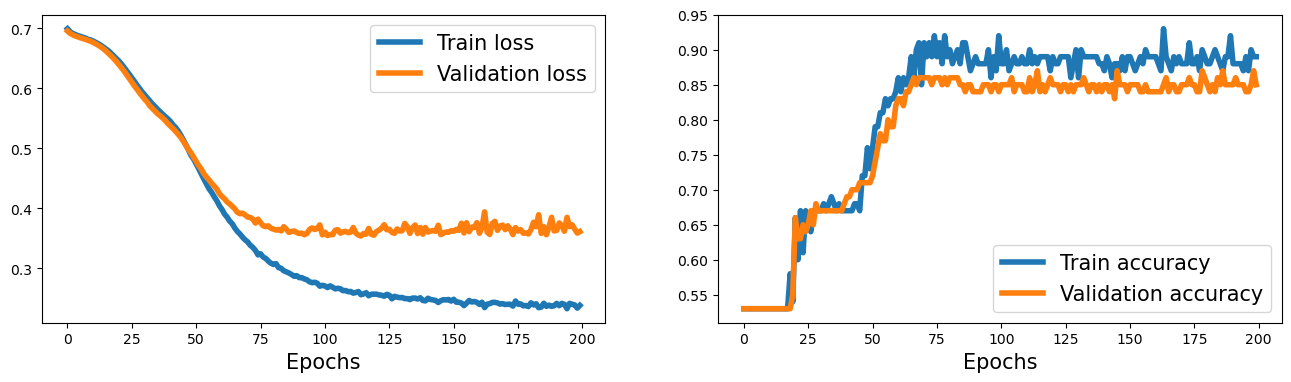

In [12]:
model = nn.Sequential(
    nn.Linear(2,4),
    nn.ReLU(),
    nn.Linear(4,4),
    nn.ReLU(),
    nn.Linear(4,1),
    nn.Sigmoid(),
)
optimizer = torch.optim.SGD(model.parameters(),lr=0.015)
history = train(model,num_epochs,train_dl,x_valid,y_valid)

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0],lw=4)
plt.plot(history[1],lw=4)
plt.legend(["Train loss","Validation loss"],fontsize=15)
ax.set_xlabel("Epochs",size=15)
ax = fig.add_subplot(1,2,2)
plt.plot(history[2],lw=4)
plt.plot(history[3],lw=4)
plt.legend(["Train accuracy","Validation accuracy"],fontsize=15)
ax.set_xlabel("Epochs",size=15)

# Making model building more flexible with `nn.Module`

In [13]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.__w = nn.Sequential(
            nn.Linear(2,4),
            nn.ReLU(),
            nn.Linear(4,4),
            nn.ReLU(),
            nn.Linear(4,1),
            nn.Sigmoid(),
        )

    def forward(self,x):
        return self.__w(x)

    def predict(self,x):
        x = torch.tensor(x,dtype=torch.float32)
        pred = self.forward(x)[:,0]
        return (pred >= 0.5).float()

model = MyModule()
optimizer = torch.optim.SGD(model.parameters(),lr=0.015)
history = train(model,num_epochs,train_dl,x_valid,y_valid)

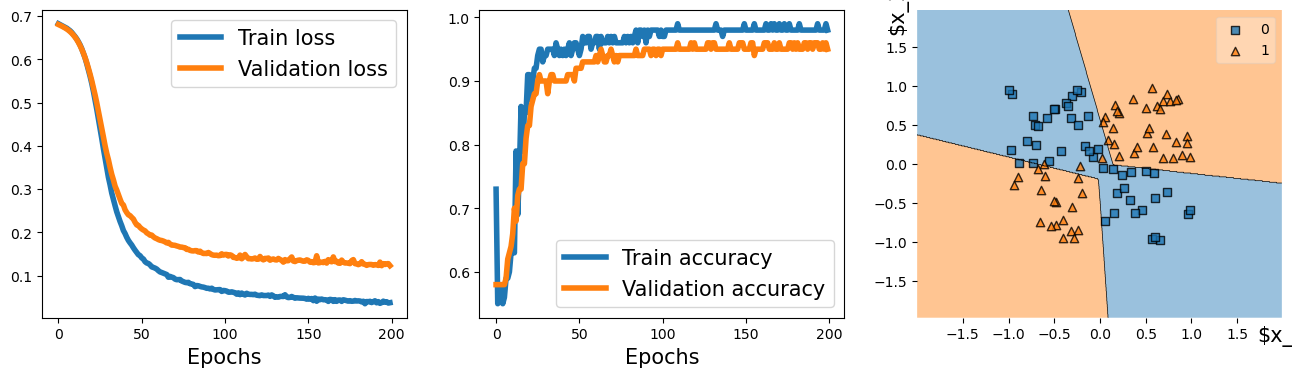

In [14]:
from mlxtend.plotting import plot_decision_regions
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,3,1)
plt.plot(history[0],lw=4)
plt.plot(history[1],lw=4)
plt.legend(["Train loss","Validation loss"],fontsize=15)
ax.set_xlabel("Epochs",size=15)
ax = fig.add_subplot(1,3,2)
plt.plot(history[2],lw=4)
plt.plot(history[3],lw=4)
plt.legend(["Train accuracy","Validation accuracy"],fontsize=15)
ax.set_xlabel("Epochs",size=15)
ax = fig.add_subplot(1,3,3)
plot_decision_regions(X=x_valid.numpy(),y=y_valid.numpy().astype(np.int32),clf=model)
ax.set_xlabel(r'$x_1',size=15)
ax.xaxis.set_label_coords(1,-0.025)
ax.set_ylabel(r'$x_2',size=15)
ax.yaxis.set_label_coords(-0.025,1)
plt.show()

# Writing custom layers in PyTorch

In [15]:
class NoisyLinear(nn.Module):
    def __init__(self,input_size, output_size, noise_stdev = 0.1):
        super().__init__()
        w = torch.Tensor(input_size,output_size)
        self.w = nn.Parameter(w) # Now the w tensor just became a module parameter
        nn.init.xavier_uniform_(self.w)
        b = torch.zeros(output_size)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stdev

    def forward(self, x, training=False):
        x_new = x
        if training:
            noise = torch.normal(0.0,self.noise_stddev,x.shape)
            x_new = torch.add(x,noise)
        
        return torch.add(x_new@self.w,self.b)

In [16]:
torch.manual_seed(1)
noisy_linear = NoisyLinear(4,2)
x = torch.zeros((1,4))
print(noisy_linear(x,training=True))
print(noisy_linear(x,training=True))
print(noisy_linear(x,training=True))

tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)
tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)
tensor([[-0.0366,  0.0022]], grad_fn=<AddBackward0>)


In [17]:
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.__nois_lin = NoisyLinear(2,4,0.07)
        self.__w = nn.Sequential(
            nn.ReLU(),
            nn.Linear(4,4),
            nn.ReLU(),
            nn.Linear(4,1),
            nn.Sigmoid(),
        )
    def forward(self,x,training=False):
        x = self.__nois_lin(x,training=training)
        return self.__w(x)

    def predict(self,x):
        x = torch.tensor(x,dtype=torch.float32)
        pred = self.forward(x)[:,0]
        return (pred >= 0.5).float()

torch.manual_seed(1)
model = MyNoisyModule()
optimizer = torch.optim.SGD(model.parameters(),lr=0.015)
history = train(model,num_epochs,train_dl,x_valid,y_valid)

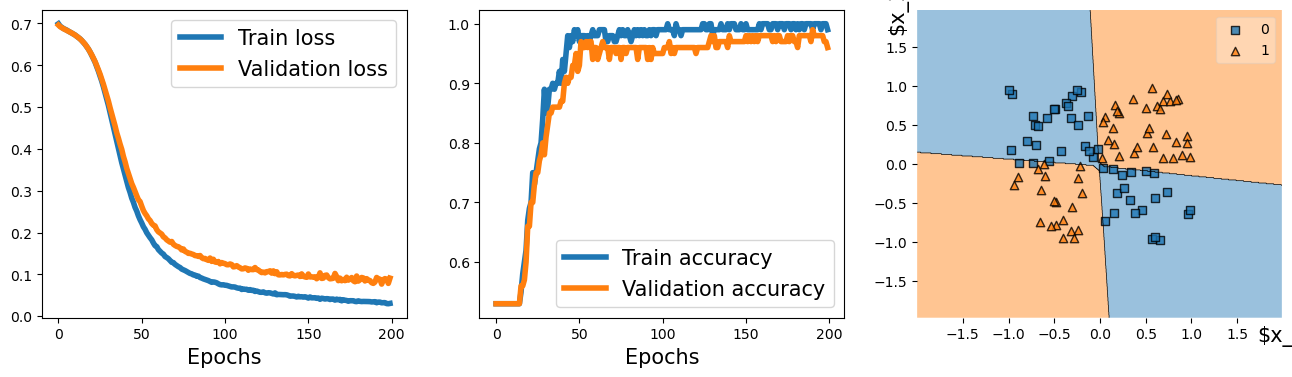

In [18]:
from mlxtend.plotting import plot_decision_regions
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(["Train loss", "Validation loss"], fontsize=15)
ax.set_xlabel("Epochs", size=15)
ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(["Train accuracy", "Validation accuracy"], fontsize=15)
ax.set_xlabel("Epochs", size=15)
ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), y=y_valid.numpy().astype(np.int32), clf=model)
ax.set_xlabel(r"$x_1", size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r"$x_2", size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()